In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('.'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# test_phantom = phantom.Phantom(source_path = None,
#             voxel_dims = (0.25e-3,0.25e-3,0.25e-3),
#             matrix_dims = (256,256,128),
#             baseline = (1500, 1000),
#             seed = 5678,)

# water = tissue.Tissue(name='water', c=1500, rho=1000, sigma=0, scale=0.001, label=0)
# wire = tissue.Tissue(name='wire', c=2000, rho=1400, sigma=0, scale=0.001, label=1)

# pos = 0.016
# test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

# wire_mask = np.zeros(test_phantom.matrix_dims)
# wire_mask[160,160,:] = 1
# wire_mask[128,128,:] = 1
# wire_mask[128,192,:] = 1
# wire_mask[192,128,:] = 1
# wire_mask[192,192,:] = 1
# wire_mask[96,96,:] = 1
# wire_mask[96,224,:] = 1
# wire_mask[224,96,:] = 1
# wire_mask[224,224,:] = 1
# test_phantom.add_tissue(wire, mask=wire_mask)
    
# test_phantom.set_default_tissue('water')
# test = test_phantom.get_complete()


test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (128,128,64),
            baseline = (1500, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1500, rho=1000, sigma=0, scale=0.001, label=0)
wire = tissue.Tissue(name='wire', c=2000, rho=1400, sigma=0, scale=0.001, label=1)

pos = 0.016
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

wire_mask = np.zeros(test_phantom.matrix_dims)
wire_mask[80,80,:] = 1
wire_mask[64,64,:] = 1
wire_mask[64,96,:] = 1
wire_mask[96,64,:] = 1
wire_mask[96,96,:] = 1
wire_mask[48,48,:] = 1
wire_mask[48,112,:] = 1
wire_mask[112,48,:] = 1
wire_mask[112,112,:] = 1
test_phantom.add_tissue(wire, mask=wire_mask)
    
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

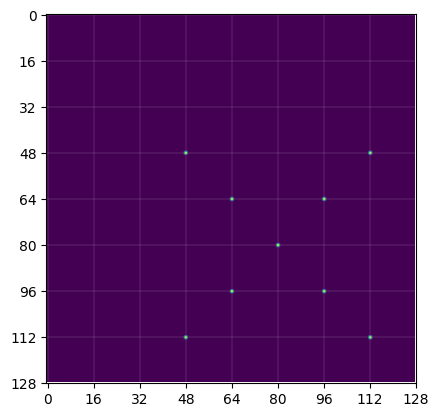

In [3]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])

plt.gca().set_xticks(np.linspace(0, test_phantom.matrix_dims[1],9))
plt.gca().set_yticks(np.linspace(0, test_phantom.matrix_dims[0],9))
plt.gca().grid(color='w', linestyle='-', linewidth=0.1)

In [4]:
num_transducers = 2
transducers = [transducer.Planewave(max_frequency=1.9e6,
                                    elements = 256, 
                                    width = 36e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/4,
                                    ray_num = 5,
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

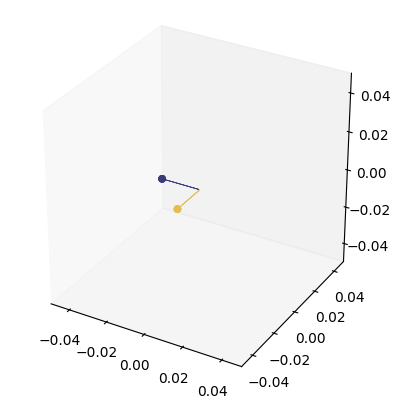

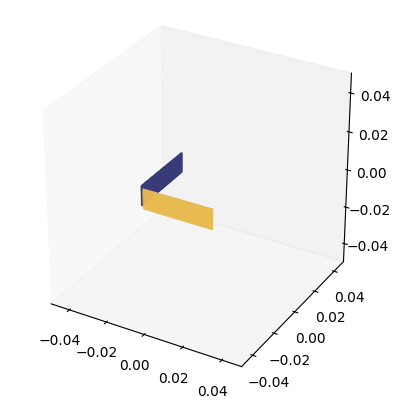

In [5]:
cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
cont_transducer_set.assign_pose(0, geometry.Transform([0,0,0], [-0.02,0,0]))
cont_transducer_set.assign_pose(1, geometry.Transform([np.pi/2,0,0], [0,-0.02,0]))


cont_transducer_set.plot_transducer_fovs(scale=0.05)
cont_transducer_set.plot_transducer_coords(scale=0.05)

In [6]:
extended_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='extended_aperture')
tar_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='transmit_as_receive')

In [7]:
simprops = simulation.SimProperties(
                grid_size   = (50e-3,55e-3,20e-3),
                PML_size    = (16,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [8]:
extended_experiment = experiment.Experiment(
                 simulation_path = 'extended_aperture_x',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

tar_experiment = experiment.Experiment(
                 simulation_path = 'tar_aperture_x',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = tar_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = []
                 )

extended_experiment.save()
tar_experiment.save()

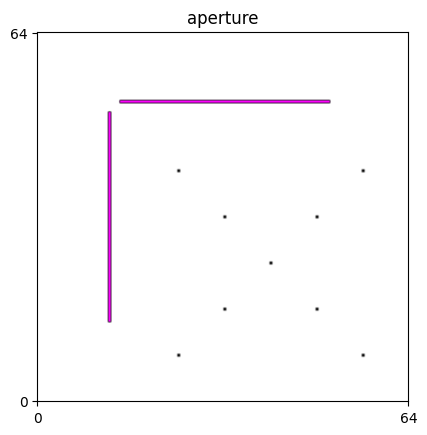

In [9]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2+1])
plt.gca().set_title('aperture')
plt.gca().set_xticks([-1,128])
plt.gca().set_xticklabels(['0','64'])
plt.gca().set_yticks([0,128])
plt.gca().set_yticklabels(['64','0'])
plt.savefig('x_phantom.png', dpi=300, bbox_inches="tight")

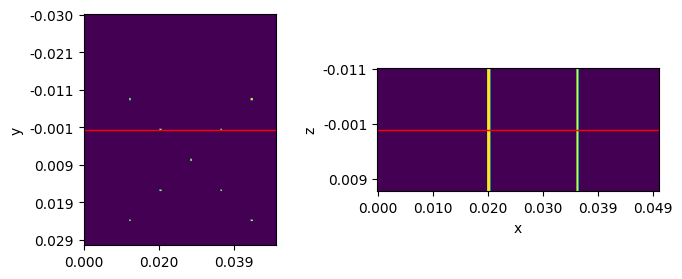

In [10]:
extended_experiment.plot_ray_path(0)

In [11]:
test_experiment = experiment.Experiment.load('tar_aperture_x')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

running with 2 workers



preparation for sim    0 completed in 13.14 seconds
preparation for sim    1 completed in 15.39 seconds
simulation             0 completed in 51.16 seconds
preparation for sim    2 completed in 16.12 seconds
simulation             1 completed in 47.92 seconds
preparation for sim    3 completed in 15.62 seconds
simulation             2 completed in 61.39 seconds
preparation for sim    4 completed in 15.14 seconds
simulation             3 completed in 64.00 seconds
preparation for sim    5 completed in 16.92 seconds
simulation             4 completed in 65.61 seconds
preparation for sim    6 completed in 13.93 seconds
simulation             5 completed in 47.19 seconds
preparation for sim    7 completed in 13.79 seconds
simulation             6 completed in 58.93 seconds
preparation for sim    8 completed in 14.01 seconds
simulation             7 completed in 51.43 seconds
preparation for sim    9 completed in 17.83 seconds
simulation             8 completed in 60.33 seconds
simulation  

In [12]:
test_experiment = experiment.Experiment.load('extended_aperture_x')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

running with 2 workers



preparation for sim    0 completed in 10.16 seconds
preparation for sim    1 completed in 18.75 seconds


simulation             0 completed in 67.31 seconds
preparation for sim    2 completed in 16.68 seconds
simulation             1 completed in 64.02 seconds
preparation for sim    3 completed in 16.32 seconds
simulation             2 completed in 58.14 seconds
preparation for sim    4 completed in 17.40 seconds
simulation             3 completed in 54.17 seconds
preparation for sim    5 completed in 15.13 seconds
simulation             4 completed in 52.45 seconds
preparation for sim    6 completed in 17.02 seconds
simulation             5 completed in 55.29 seconds
preparation for sim    7 completed in 14.10 seconds
simulation             6 completed in 54.35 seconds
preparation for sim    8 completed in 14.89 seconds
simulation             7 completed in 49.88 seconds
preparation for sim    9 completed in 15.30 seconds
simulation             8 completed in 52.36 seconds
simulation             9 completed in 52.25 seconds
successfully joined 1 preparation processes and 1 run process


# Reconstruction

In [13]:
test_experiment = experiment.Experiment.load('tar_aperture_x')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


In [14]:
images1 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 10/10 [00:00<00:00, 235635.06it/s]


182
182
182
182
182
182
182
182
182
182


In [15]:
image1 = np.sum(images1, axis=0)/len(images1)
image1t1 = np.sum(images1[:len(images1)//2], axis=0)/len(images1)//2
image1t2 = np.sum(images1[len(images1)//2:], axis=0)/len(images1)//2
image1_mult = np.multiply(image1t1, image1t2)

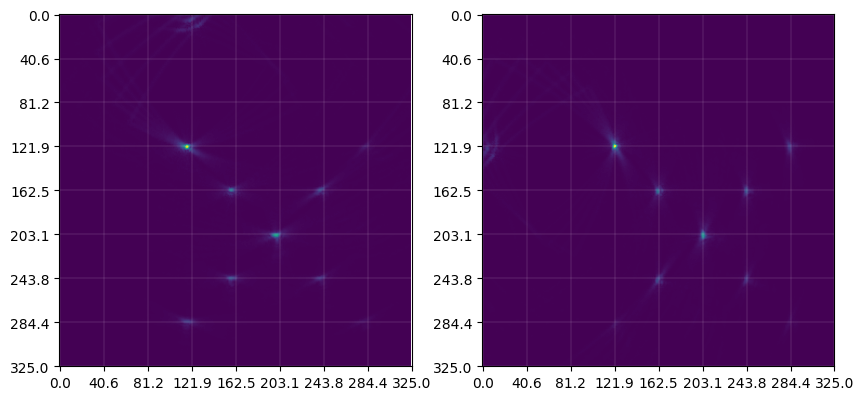

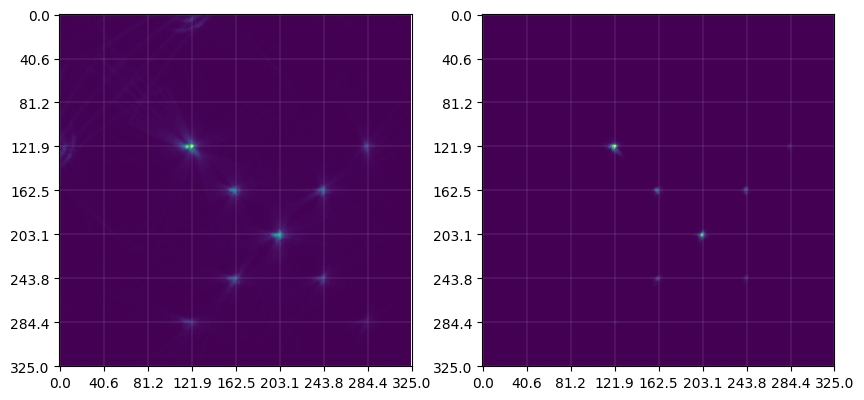

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image1t1)
ax[1].imshow(image1t2)
for a in ax:
    a.set_xticks(np.linspace(0, image1.shape[1],9))
    a.set_yticks(np.linspace(0, image1.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image1[:,:,image1.shape[2]//2])
ax[1].imshow(image1_mult[:,:,image1_mult.shape[2]//2])
for a in ax:
    a.set_xticks(np.linspace(0, image1.shape[1],9))
    a.set_yticks(np.linspace(0, image1.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)

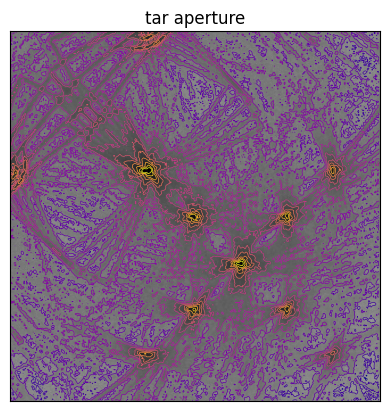

In [17]:
psf = 20 * np.log10(image1 / 1000000) # source_strength set to 1e6
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

im = ax.imshow(image, cmap='gray_r', vmin=-100, vmax=0)
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,-5])
# ax.clabel(CS, inline=True, fontsize=5)
ax.set_title('tar aperture')
ax.set_xticks([])
ax.set_yticks([])
# plt.colorbar(im)
plt.savefig('x_tar_aperture.png', dpi=300, bbox_inches="tight")

In [18]:
test_experiment = experiment.Experiment.load('extended_aperture_x')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


In [19]:
images2 = test_reconstruction.compound(workers=1, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 10/10 [00:00<00:00, 219597.07it/s]


512
512
512
512
512
512
512
512
512
512


In [20]:
image2 = np.sum(images2, axis=0)
image2t1 = np.sum(images2[:len(images2)//2], axis=0)
image2t2 = np.sum(images2[len(images2)//2:], axis=0)
image2_mult = np.multiply(image2t1, image2t2)

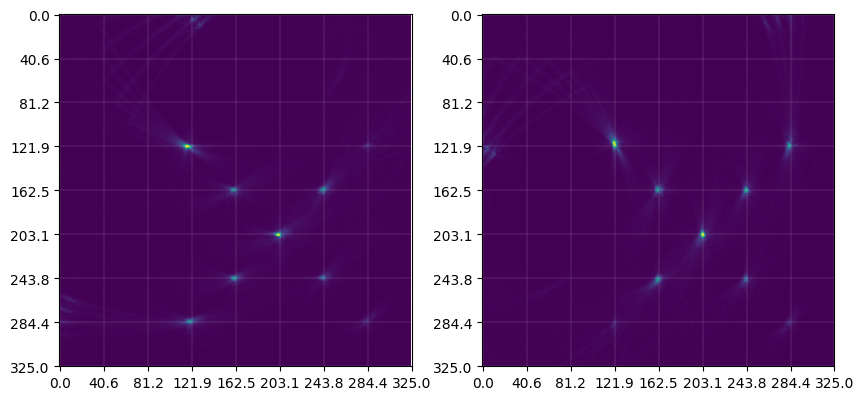

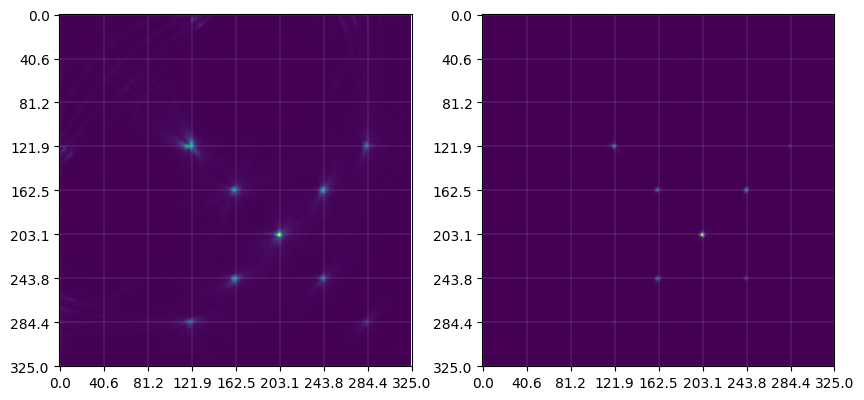

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image2t1)
ax[1].imshow(image2t2)
for a in ax:
    a.set_xticks(np.linspace(0, image2.shape[1],9))
    a.set_yticks(np.linspace(0, image2.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image2[:,:,image2.shape[2]//2])
ax[1].imshow(image2_mult[:,:,image2_mult.shape[2]//2])
for a in ax:
    a.set_xticks(np.linspace(0, image2.shape[1],9))
    a.set_yticks(np.linspace(0, image2.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)

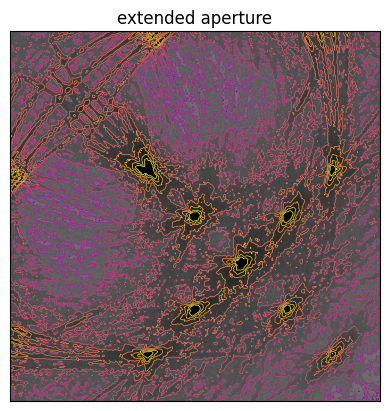

In [24]:
psf = 20 * np.log10(image2 / 4 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

im = ax.imshow(image, cmap='gray_r', vmin=-100, vmax=0)
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,-5])
# ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('extended aperture')
ax.set_xticks([])
ax.set_yticks([])
# plt.colorbar(im)
plt.savefig('x_extended_aperture.png', dpi=300, bbox_inches="tight")

In [23]:
assert False

AssertionError: 

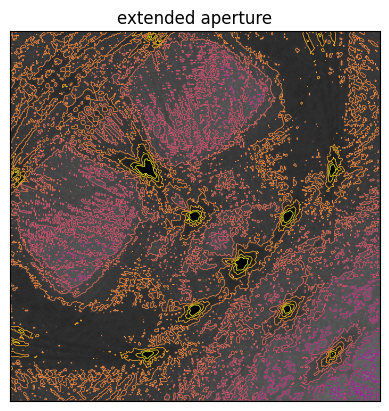

In [ ]:
# 64 elements

psf = 20 * np.log10(image2 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

im = ax.imshow(image, cmap='gray_r', vmin=-100, vmax=0)
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,-5])
# ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('extended aperture')
ax.set_xticks([])
ax.set_yticks([])
# plt.colorbar(im)
plt.savefig('x_extended_aperture.png', dpi=300, bbox_inches="tight")